In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import metaflux
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
import learn2learn as l2l
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(101)
torch.manual_seed(101)
import warnings
from tqdm import tqdm
import copy

import imageio
import glob
from pyhdf.SD import SD, SDC

/home/user/anaconda3/envs/pytorch/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## Helper functions

In [3]:
def generate_datacube(year):
    """Generating datacube with ERA5 and RS (eg. EVI)"""
    coarseness = 20
    evi_files = glob.glob(f"../../Data/rs/evi/{year}/*.hdf")
    evi_files.sort()
    all_d = []

    for evi_f in evi_files:
        evi_d = SD(evi_f).select("CMG 0.05 Deg Monthly EVI")[:]
        temp = evi_d.reshape((evi_d.shape[0] // coarseness, coarseness, evi_d.shape[1] // coarseness, coarseness))
        evi_d = np.mean(temp, axis=(1,3))
        all_d.append(evi_d)

    # Generate datacube with ERA5 and resolve resolution to 1-degree
    coarseness = 4
    era5 = xr.open_dataset(f"../../Data/era5/monthly/monthly_{year}.nc")
    era5 = era5.assign_coords(longitude=(((era5.longitude + 180) % 360) - 180)).sortby('longitude') # shift
    era5 = era5.coarsen(latitude=coarseness, longitude=coarseness, boundary="trim").mean()

    era5['evi'] = (("time", "latitude", "longitude"), np.array(all_d))

    return era5
    

In [4]:
# Retrieve individual variables
def process_era5(era5, xs):
    """Function to process era5 data and make it usable with the inference model
    
    Parameter
    ---------
    era5: xarray.DataArray
        the loaded era5 data in xarray format
    xs: list of str
        list of used columns within era5
        
    Return
    --------
    lat: list of float
        latitude of the dataset
    lng: list of float
        longitude of the dataset
    stacked: torch.Tensor()
        era5 data in tensor format
    """
    lat, lng = era5.latitude, era5.longitude
    shape = (-1,1) # (flattened, sequence_len, num_vars)
    combined = []

    def _get_vpd(era5):
        power_avp = (17.13 * (era5['d2m'] - 273.16)) / (era5['d2m'] - 38)
        avp = 6.1078 * np.exp(power_avp)
        power_svp = (17.13 * (era5['t2m'] - 273.16)) / (era5['t2m'] - 38)
        svp = 6.1078 * np.exp(power_svp)
        era5['vpd'] = svp - avp

        return era5
    
    for var in xs:
        if xs == 'd2m':
            era5 = _get_vpd(era5)
            var = 'vpd'

        era5_vals = era5[var].data.reshape(shape)
        era5_vals = (era5_vals - era5_vals.mean()) / era5_vals.std()
        combined.append(era5_vals)
        
    combined = np.transpose(np.array(combined), axes=[1,2,0])
    combined = torch.Tensor(combined).to(device)
        
    return lat, lng, combined

In [5]:
def meta_infer(model, x, batch_sz=2000):
    """ Function used for inference
    
    Parameter
    ---------
    model: list of obj
        the trained model(s) for inference
    x: torch.Tensor
        the input tensor
    batch_sz: int
        the batch size for each inference
        
    Return
    --------
    y_hats: ndarray
        the prediction tensor
    """
    
    y_hats = []
    groups = int(x.shape[0] / batch_sz)
    net = model.clone().double()
    
    for i in tqdm(range(groups)):
        x_subs = x[i * batch_sz : i * batch_sz + batch_sz,:,:].double()
        y_hat = net.linear_out(net(x_subs)).detach().cpu().squeeze()
        y_hats.append(y_hat)
    
    # Remainder group
    x_subs = x[groups * batch_sz:,:,:].double()
    y_hat = net.linear_out(net(x_subs)).detach().cpu().squeeze()
    y_hats.append(y_hat)
    y_hats = torch.cat(y_hats, dim=0)
    
    assert y_hats.shape[0] == x.shape[0]
        
    return y_hats

In [6]:
# retrieve koppen climate classification (tropics vs non-tropics)
koppen = xr.open_dataset("../../Data/koppen/Beck_KG_V1_present_0p0083.tif")
era5 = generate_datacube(year=2021)

climate_zns = []
for lat in tqdm(era5.latitude.data):
    for lng in era5.longitude.data:
        kpn_clf = koppen.sel(x=lng, y=lat, method='nearest')['band_data'].data
        kpn_clf = int(kpn_clf[0])
        climate_zns.append(kpn_clf)

climate_zns = np.array(climate_zns).reshape(1, len(era5.latitude), len(era5.longitude))
zns = climate_zns.repeat(12,0)
zns = zns.reshape(12, len(era5.latitude), len(era5.longitude))
era5["climate_zns"] = (['time', 'latitude', 'longitude'], zns)

/home/user/anaconda3/envs/pytorch/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
100%|██████████| 180/180 [01:07<00:00,  2.66it/s]


## Upscaling

In [220]:
# Define inputs
year = 2021
targets = ['GPP_NT_VUT_REF', 'RECO'] # valid values: ['GPP_NT_VUT_REF', 'RECO']

# Process ERA5 and load model
cols = ['tp','lai_hv','d2m','evi'] # valid values: ['tp','lai_hv','ssrd','d2m','t2m','evi']
lat, lng, era5_x = process_era5(era5, xs=cols)

y_all = []
for target in targets:
    maml = torch.load(f"../../model_dir/maml_mlp_{target}.pt")

    # Inference
    y_hat = meta_infer(maml, era5_x)
    y_hat = y_hat.numpy().reshape(len(era5.time), len(lat), len(lng))

    # masking land-sea-ice
    y_valid = xr.where((era5['climate_zns'] > 0) & (era5['climate_zns'] < 30), y_hat, np.nan)
    y_all.append(y_valid.data)


# Construct xarray dataset
ds = xr.Dataset(
    data_vars=dict(
        GPP=(
                ["time", "latitude", "longitude"], 
                y_all[0], 
                {'units': '$gCm^{-2}d^{-1}$', 
                'long_name':'Gross Primary Production (GPP)'}
            ),
        RECO=(
                ["time", "latitude", "longitude"], 
                y_all[1], 
                {'units': '$gCm^{-2}d^{-1}$', 
                'long_name':'Ecosystem Respiration (Reco)'}
            ),
        ),
        
        coords=dict(
            time=(['time'], era5.time.data),
            latitude=(["latitude"], era5.latitude.data),
            longitude=(["longitude"], era5.longitude.data)
        ),
        attrs=dict(description="Upscaling of Sparse Carbon Flux using Meta-Learning")
    )

# Compress and save as NetCDF
#     comp = dict(zlib=True, complevel=5)
#     encoding = {var: comp for var in ds.data_vars}

#     ds.to_netcdf(f'./Data/era5/monthly/metalearning_monthly_yr{y}.nc', encoding=encoding)

/home/user/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py:561: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  if param.grad is not None:
100%|██████████| 388/388 [00:00<00:00, 574.51it/s]


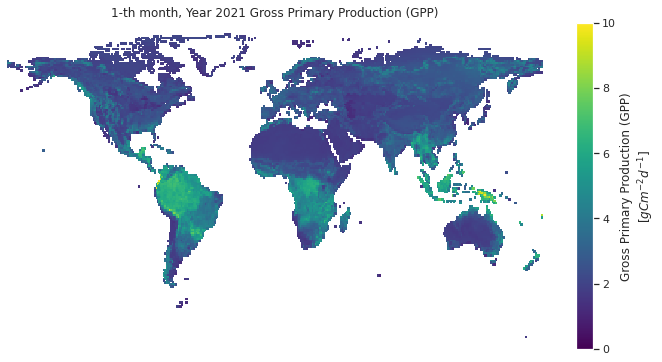

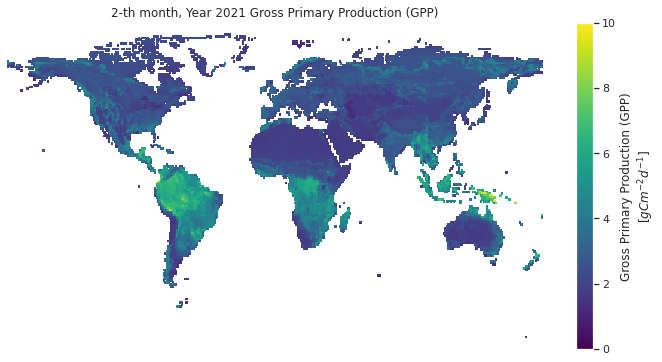

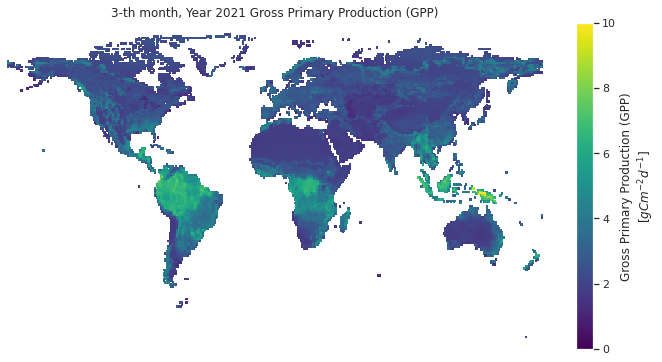

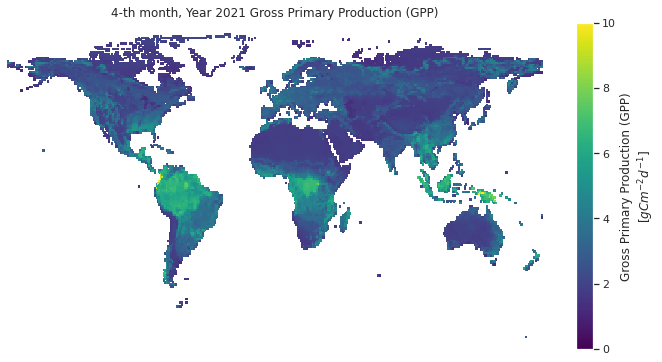

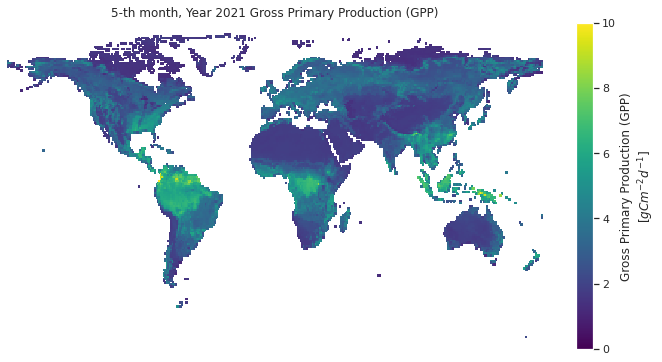

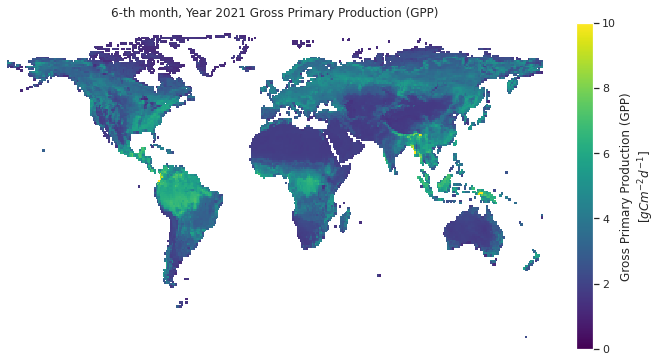

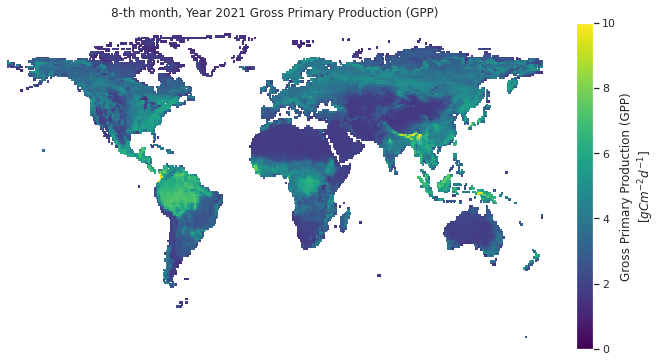

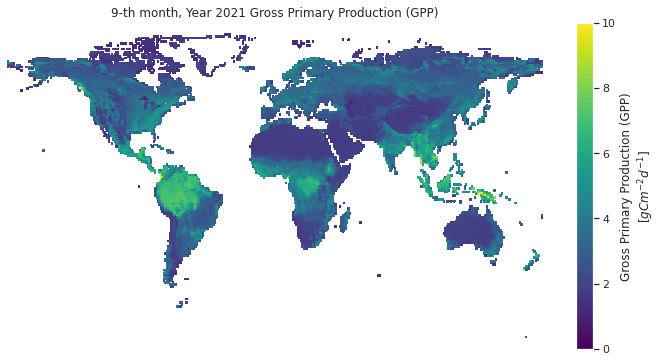

In [226]:
da = ds['GPP']
for i in range(da.shape[0]):
    fig, ax = plt.subplots(figsize=(12,6))
    subf = da[i].plot(cmap='viridis', ax=ax)
    ax.set_title(f'{i+1}-th month, Year 2021 Gross Primary Production (GPP)')
    subf.set_clim(0,10)
    ax.axis('off')

    if i < 9:
        plt.savefig(f'../../Docs/output/gpp_2021/0{i+1}.jpg', bbox_inches='tight')
    else:
        plt.savefig(f'../../Docs/output/gpp_2021/{i+1}.jpg', bbox_inches='tight')

# animation
images = []
filenames = glob.glob('../../Docs/output/gpp_2021/*.jpg')
filenames.sort()
for filename in filenames:
    images.append(imageio.imread(filename))
    
imageio.mimsave('../../Docs/output/gpp_2021/gpp_norm.gif', images, fps=1)

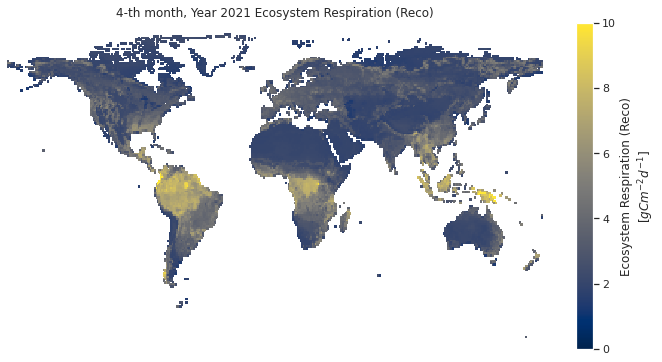

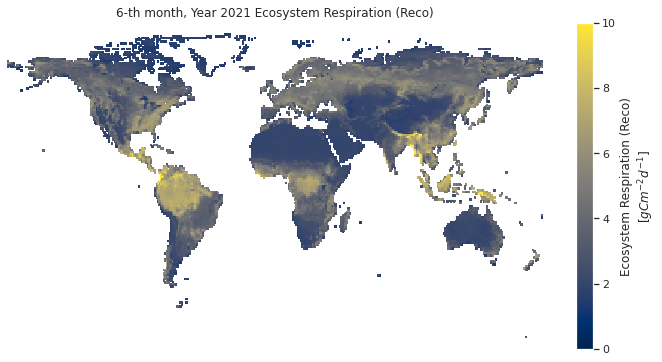

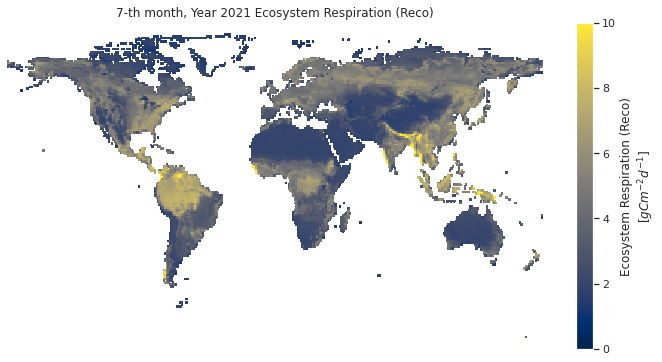

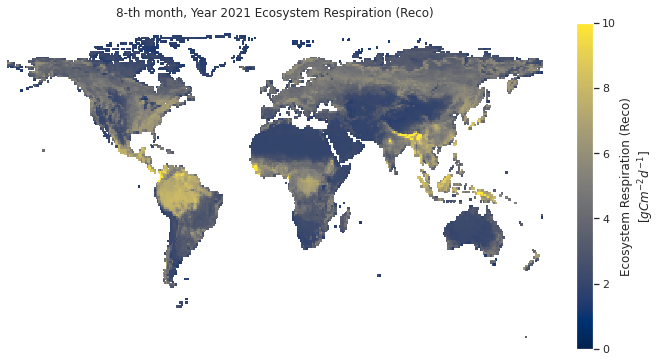

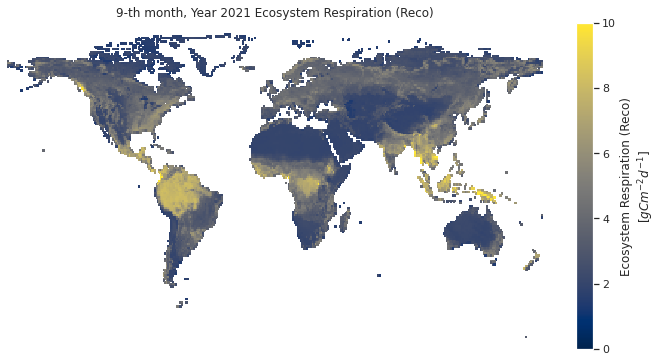

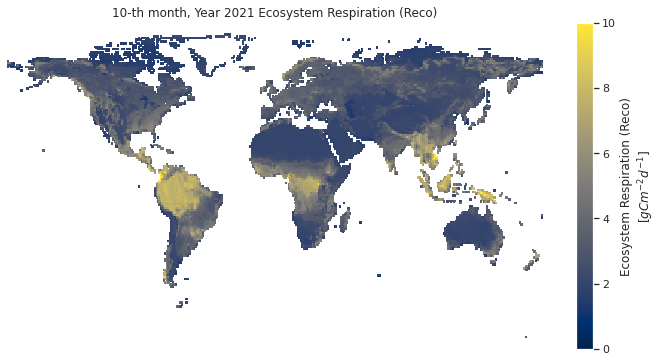

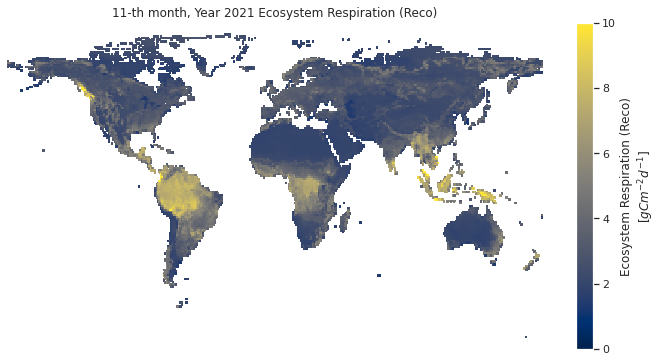

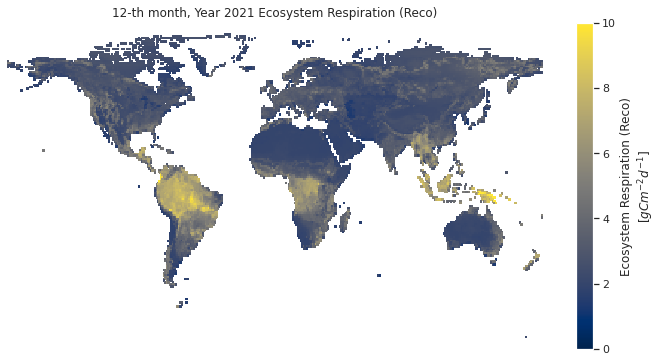

In [227]:
da = ds['RECO']
for i in range(da.shape[0]):
    fig, ax = plt.subplots(figsize=(12,6))
    subf = da[i].plot(cmap='cividis', ax=ax)
    ax.set_title(f'{i+1}-th month, Year 2021 Ecosystem Respiration (Reco)')
    subf.set_clim(0,10)
    ax.axis('off')

    if i < 9:
        plt.savefig(f'../../Docs/output/reco_2021/0{i+1}.jpg', bbox_inches='tight')
    else:
        plt.savefig(f'../../Docs/output/reco_2021/{i+1}.jpg', bbox_inches='tight')

# animation
images = []
filenames = glob.glob('../../Docs/output/reco_2021/*.jpg')
filenames.sort()
for filename in filenames:
    images.append(imageio.imread(filename))
    
imageio.mimsave('../../Docs/output/reco_2021/reco_norm.gif', images, fps=1)

## Seasonal Analysis

In [223]:
def seasonal_analysis(era5, ds, climate_var, is_plot=True):
    climate_zns = {
        "Tropics": [1,2,3],
        "(Semi)-Arid": [4,5],
        "Temperate": [8,9,10,11,12,13,14,15,16],
        "Continental": [17,18,19,20,21,22,23,24,25,26,27,28],
        "Polar": [29,30]
        }

    climate_mean = dict()
    for climate_zn, climate_schemes in climate_zns.items():
        if climate_zn == "Temperate":
            # North
            mean_vals = []
            for t in range(len(era5.time)):
                val = xr.where((era5['climate_zns'] >= min(climate_schemes)) & (era5['climate_zns'] <= max(climate_schemes)), ds, np.nan)[climate_var].sel(time=era5.time[t], latitude=era5.latitude[0:len(era5.latitude)//2]).mean().item()
                mean_vals.append(val)

            climate_mean.update({f"{climate_zn}_north": np.array(mean_vals)})

            # South
            mean_vals = []
            for t in range(len(era5.time)):
                val = xr.where((era5['climate_zns'] >= min(climate_schemes)) & (era5['climate_zns'] <= max(climate_schemes)), ds, np.nan)[climate_var].sel(time=era5.time[t], latitude=era5.latitude[len(era5.latitude)//2:]).mean().item()
                mean_vals.append(val)

            climate_mean.update({f"{climate_zn}_south": np.array(mean_vals)})

        else:
            mean_vals = []
            for t in range(len(era5.time)):
                val = xr.where((era5['climate_zns'] >= min(climate_schemes)) & (era5['climate_zns'] <= max(climate_schemes)), ds, np.nan)[climate_var].sel(time=era5.time[t]).mean().item()
                mean_vals.append(val)
        
            climate_mean.update({climate_zn: np.array(mean_vals)})

    if is_plot:
        f, ax = plt.subplots(figsize=(8,6))
        ax.plot(climate_mean["Tropics"], label="Tropics", color="firebrick")
        ax.plot(climate_mean["(Semi)-Arid"], label="(Semi)-Arid", color="#f5a301")
        ax.plot(climate_mean["Temperate_north"], label="Temperate_north", color="#329633", ls="solid")
        ax.plot(climate_mean["Temperate_south"], label="Temperate_south", color="#329633", ls="dashed")
        ax.plot(climate_mean["Continental"], label="Continental")
        ax.set_ylabel(f"{climate_var} ({ds[climate_var].units})")
        ax.set_xlabel("Month")
        plt.xticks(np.arange(0,12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
        plt.legend()

    return climate_mean

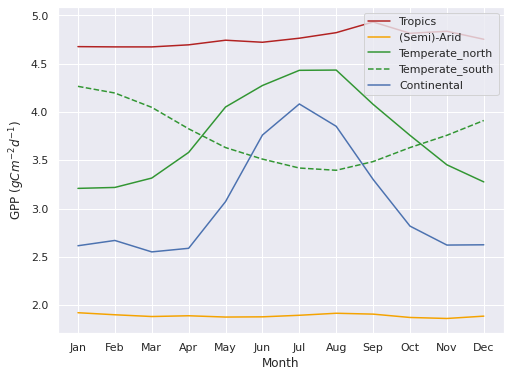

In [224]:
# Seasonal analysis for GPP
climate_var = "GPP"
climate_mean = seasonal_analysis(era5, ds, climate_var, is_plot=True)

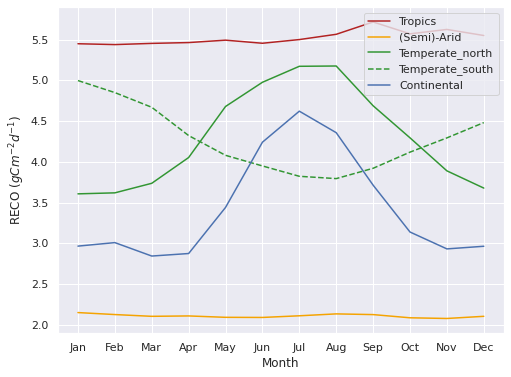

In [225]:
# Seasonal analysis for RECO
climate_var = "RECO"
climate_mean = seasonal_analysis(era5, ds, climate_var, is_plot=True)

## Inspect Inputs

<ipython-input-110-519137bf4f15>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


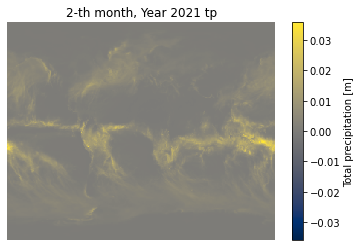

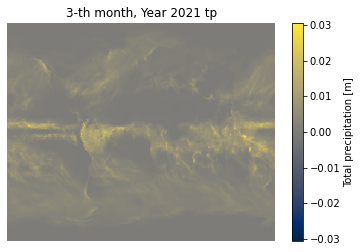

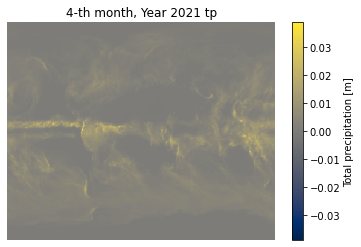

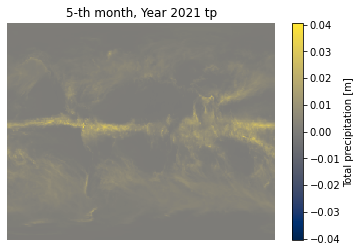

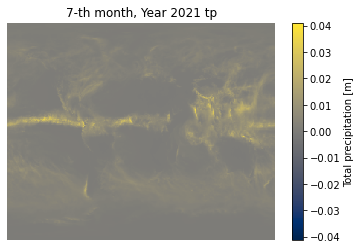

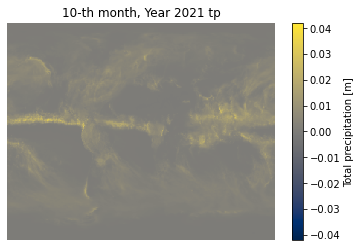

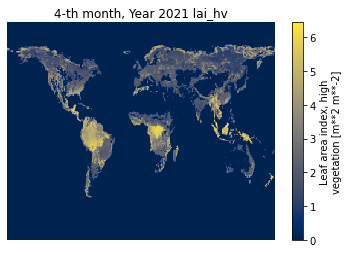

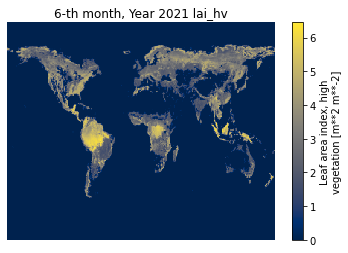

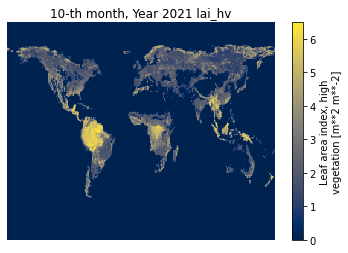

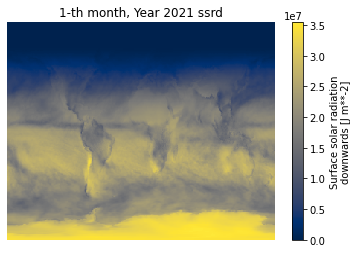

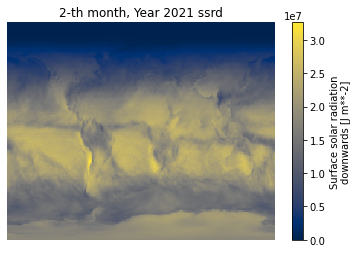

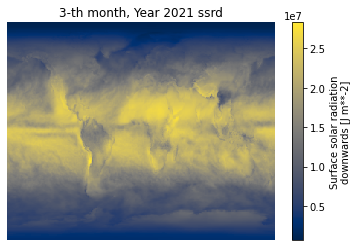

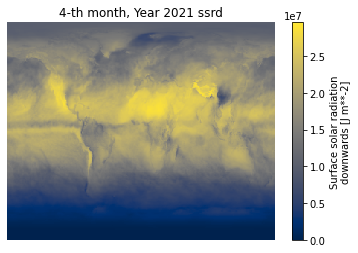

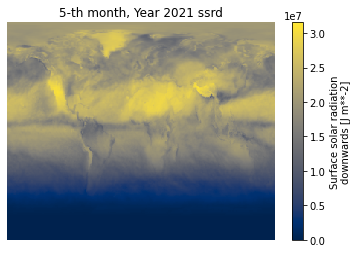

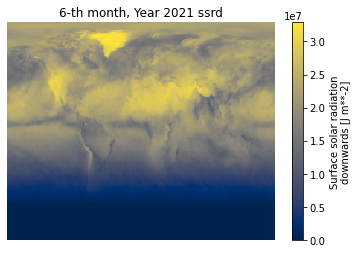

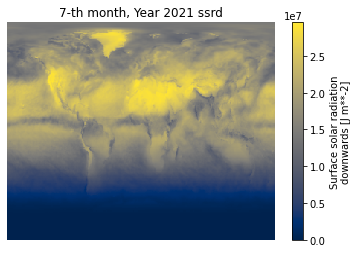

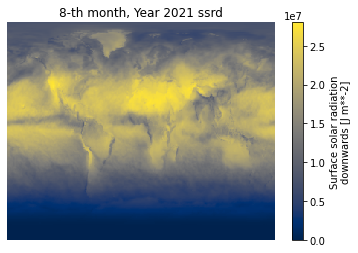

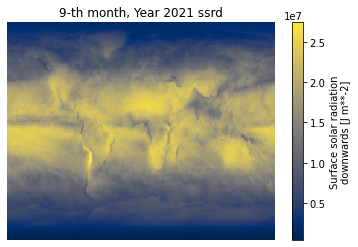

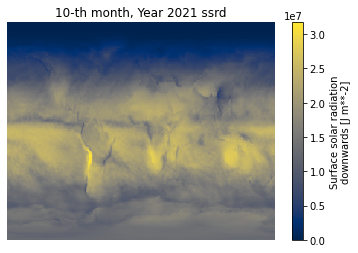

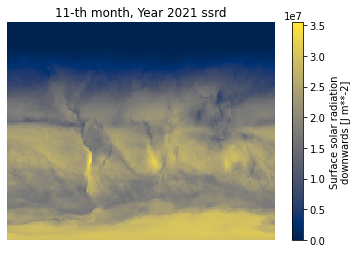

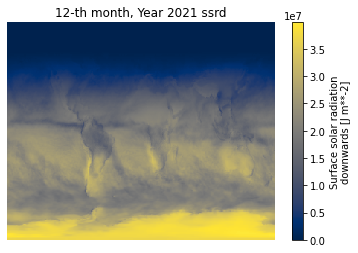

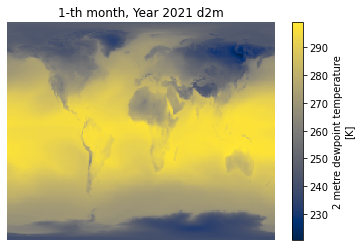

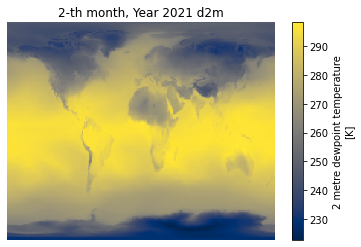

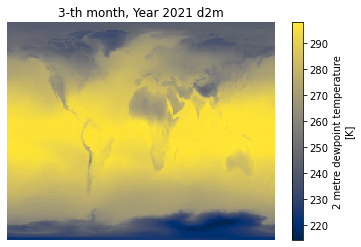

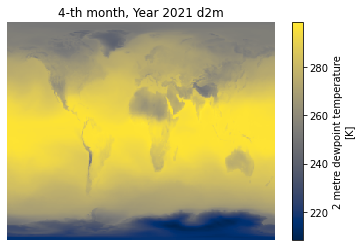

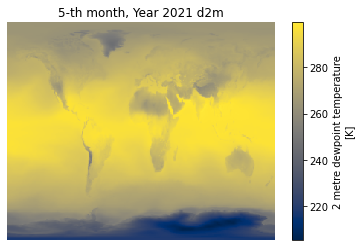

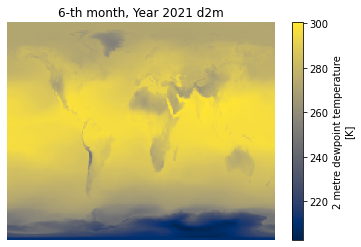

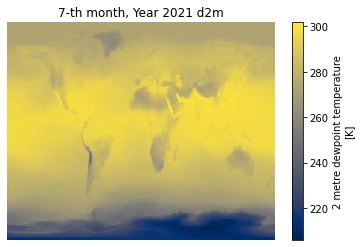

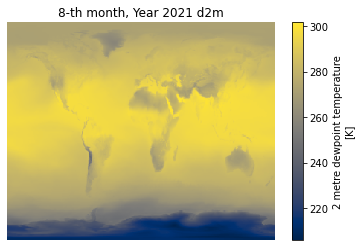

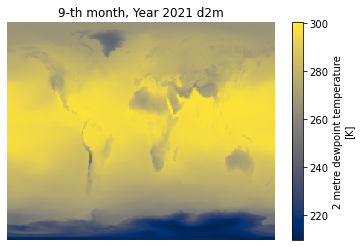

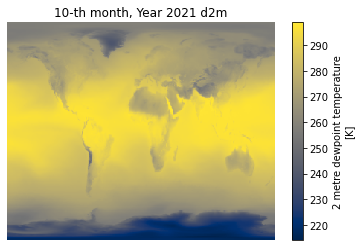

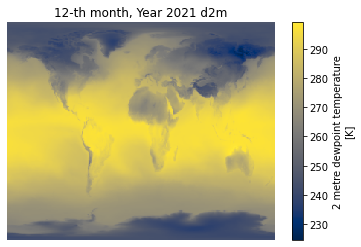

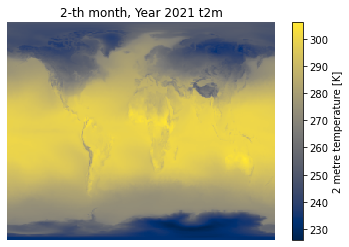

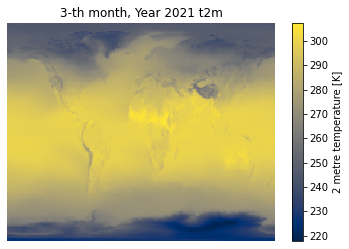

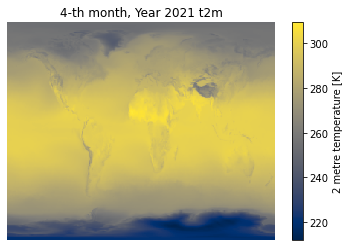

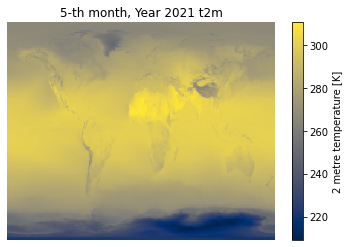

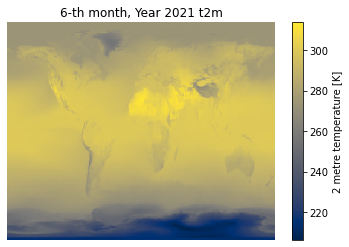

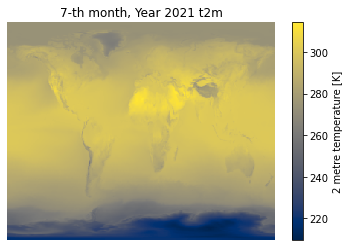

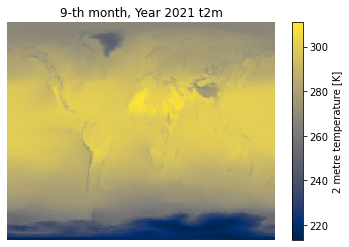

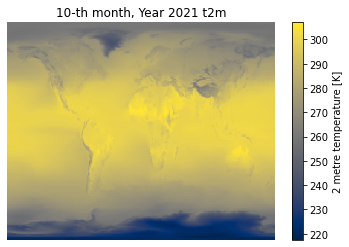

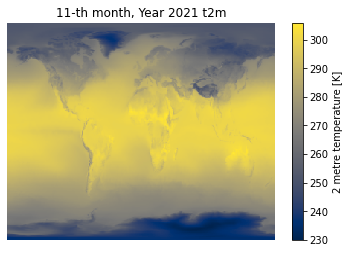

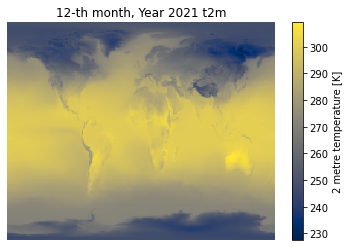

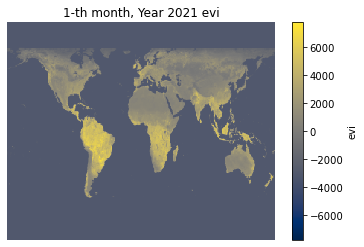

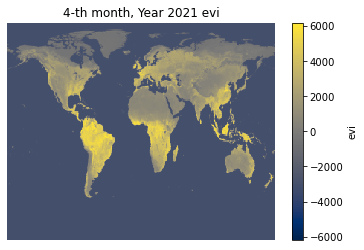

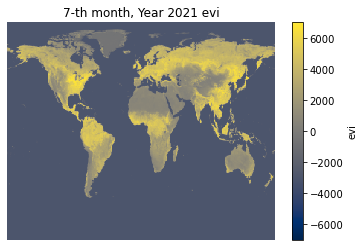

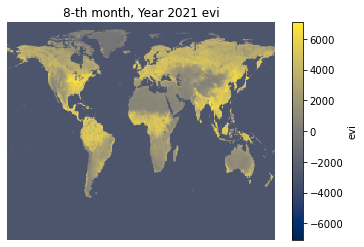

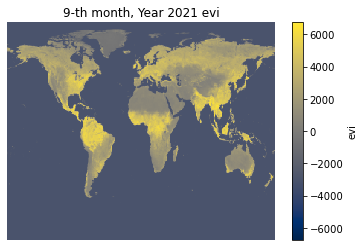

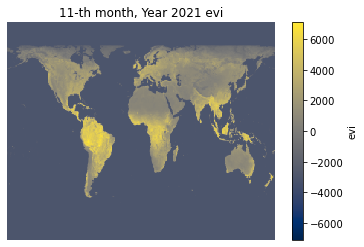

In [110]:
vars = ['tp','lai_hv','ssrd','d2m','t2m','evi']
for var in vars:
    da = era5[var]
    for i in range(da.shape[0]):
        fig, ax = plt.subplots()
        subf = da[i].plot(cmap='cividis', ax=ax)
        ax.set_title(f'{i+1}-th month, Year 2021 {var}')
        ax.axis('off')